In this project we will be making an sms spam classifer, we will be performing mutiple pre-processing step and train no. of models
Dataset that is used is a kaggle dataset.Below is the link for the dataset used.Following Step are involved
 - Data Gathering
 - Data Cleaning
 - EDA
 - Text Pre-Processing
 - Text Vectorization
 - Modeling and Evaluation
 - Improvement
 - Website

https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

In [2]:
# Import the dependencies

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk,string,re,pickle


from collections import Counter
from wordcloud import WordCloud


from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, precision_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier,StackingClassifier, VotingClassifier
from xgboost import XGBClassifier


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')


import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Loading the dataset

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download uciml/sms-spam-collection-dataset

Dataset URL: https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset
License(s): unknown
100% 211k/211k [00:00<00:00, 729kB/s]
100% 211k/211k [00:00<00:00, 728kB/s]


In [4]:
import zipfile
zip = zipfile.ZipFile('/content/sms-spam-collection-dataset.zip')
zip.extractall('/content')
zip.close()

In [5]:
# Converting into DataFrame

df = pd.read_csv('/content/spam.csv', encoding='latin-1')

In [6]:
# Checking samples

df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
2119,ham,I hope you know I'm still mad at you.,NaN,NaN,NaN
85,ham,"I call you later, don't have network. If urgnt...",NaN,NaN,NaN
1360,ham,Yo dude guess who just got arrested the other day,NaN,NaN,NaN
2934,ham,"Yeah, we got one lined up for us",NaN,NaN,NaN
1167,ham,Lol now I'm after that hot air balloon!,NaN,NaN,NaN


In [7]:
# Checking Data Shape
df.shape

(5572, 5)

- We have 5k rows and 5 columns v1 is target variable

## 1. Data Cleaning

In [8]:
# Peeking into data

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


- As observed we have 5572 rows and columns Unnamed:2,Unnamed:3 and Unnamed:4 has less than 50 values into it.

In [9]:
# Checking for missing values

df.isnull().sum()

,0
v1,0
v2,0
Unnamed: 2,5522
Unnamed: 3,5560
Unnamed: 4,5566


-- Clearly Unnamed:2, Unnamed:3 , Unnamed:4 has more than 95% of the missing values so we will drop these columns

In [10]:
# Dropping last 3 cols
df.drop(columns=['Unnamed: 2','Unnamed: 3','Unnamed: 4'],inplace=True)

In [11]:
# Checking the result post dropping

df.sample(5)

,v1,v2
4741,ham,Ya very nice. . .be ready on thursday
929,spam,money!!! you r a lucky winner ! 2 claim your p...
1479,ham,My trip was ok but quite tiring lor. Uni start...
5467,spam,Get your garden ready for summer with a FREE s...
274,ham,No objection. My bf not coming.


- V1 = Target and V2 = Text, we will rename the column to avoid confusion

In [12]:
# Renaming the columns

df.rename(columns={'v1':'target','v2':'text'},inplace=True)
df.sample(5)

,target,text
4776,ham,Sorry completely forgot * will pop em round th...
2358,ham,I'll talk to the others and probably just come...
2245,ham,How did you find out in a way that didn't incl...
1112,ham,So that means you still think of teju
4457,ham,Die... I accidentally deleted e msg i suppose ...


In [13]:
# Check the Target Variable

df.target.value_counts()

,count
target,
ham,4825
spam,747


- So we have 2 classes in target, we can apply label encoding on them

In [14]:
# Applying Label encoding on target

encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])
df

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,1,This is the 2nd time we have tried 2 contact u...
5568,0,Will Ì_ b going to esplanade fr home?
5569,0,"Pity, * was in mood for that. So...any other s..."
5570,0,The guy did some bitching but I acted like i'd...


In [15]:
# Check for Duplicate values

df.duplicated().sum()

403

- We have 403 duplicate record we will drop them.

In [16]:
# Remove duplicates

df.drop_duplicates(inplace=True)

# Checking duplicate again post dropping

df.duplicated().sum()

0

- At this point all the duplicate rows has been dropped

In [17]:
# Checking shape post removing duplicate values
df.shape

(5169, 2)

## 2.EDA

In [18]:
# Lets analyse the data

df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
# Checking the Class Distribution in Target

df['target'].value_counts()/df.shape[0]*100

,count
target,
0,87.366996
1,12.633004


87% are ham, 13% are spam, Clearly there is a class Imbalance

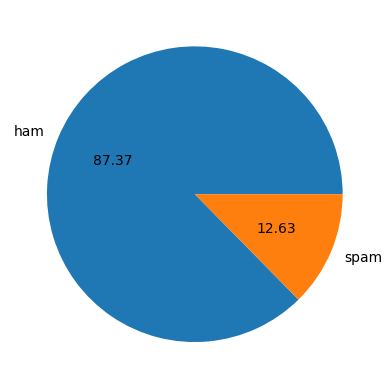

In [20]:
# Visualising using Pie Chart

plt.pie(df['target'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()

- Data is Imbalance as per Percentage

- Another Analysis we can do is we can check in our data
  - How many alphabets are used per text
  - How many words are used per per text
  - How many sentences are used per text

In [21]:
# Creating 3 new columns

# No of Characters used

df['num_characters'] = df['text'].apply(len) # No. of words in the SMS

# No. of words used
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x))) # No. of words in sms

# No. of sentences used
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x))) # No. of sentences in sms

# Checking the DataFrame post adding new columns
df.head()


,target,text,num_characters,num_words,num_sentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [22]:
# Analysing new columns

df[['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


- Max character = 901,Max words = 220, Max sentence = 38

In [23]:
# Analysing new columns with 'ham'/'0' Class of Target Variable

df[df.target==0].iloc[:,2:].describe() # df[df['target'] == 0][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [24]:
 # Analysing new columns with 'Spam'/'1' Class of Target Variable

df[df.target==1].iloc[:,2:].describe() # df[df['target'] == 1][['num_characters','num_words','num_sentences']].describe()

,num_characters,num_words,num_sentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


Observation:
 - mean value are very different
    - Mean # of character in Span Class > Mean # of character in Ham Class (137>70)
    - Mean # of words in Span Class > Mean # of words in Ham Class (27>13)
    - Mean # of sentences in Span Class > Mean # of sentences in Ham Class (3>2)

- We are getting some idea how they are different    
    

<Axes: xlabel='num_characters', ylabel='Count'>

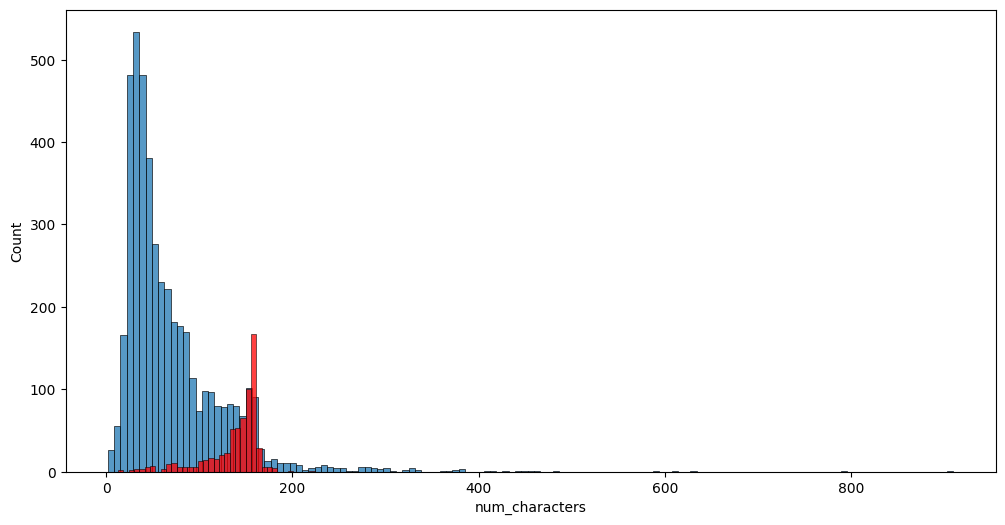

In [25]:
# Analyse using Histogram

# For Number of Characters

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_characters'])
sns.histplot(df[df['target'] == 1]['num_characters'],color='red')

- Clearly observing # of character in Ham messages are less as compare to Spam messages

<Axes: xlabel='num_words', ylabel='Count'>

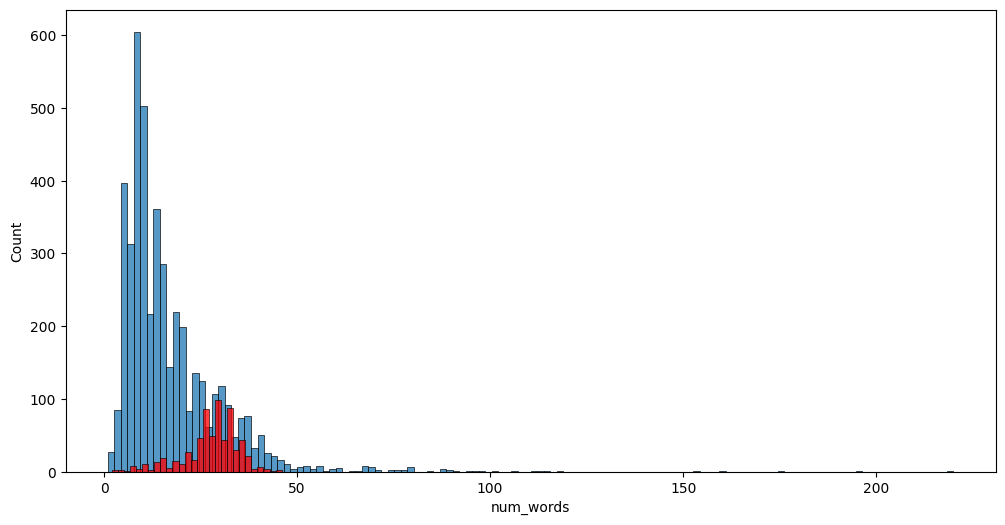

In [26]:
# For Number of words

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_words'])
sns.histplot(df[df['target'] == 1]['num_words'],color='red')

- Similar to the # of character, spam message has more words as compare to ham messages

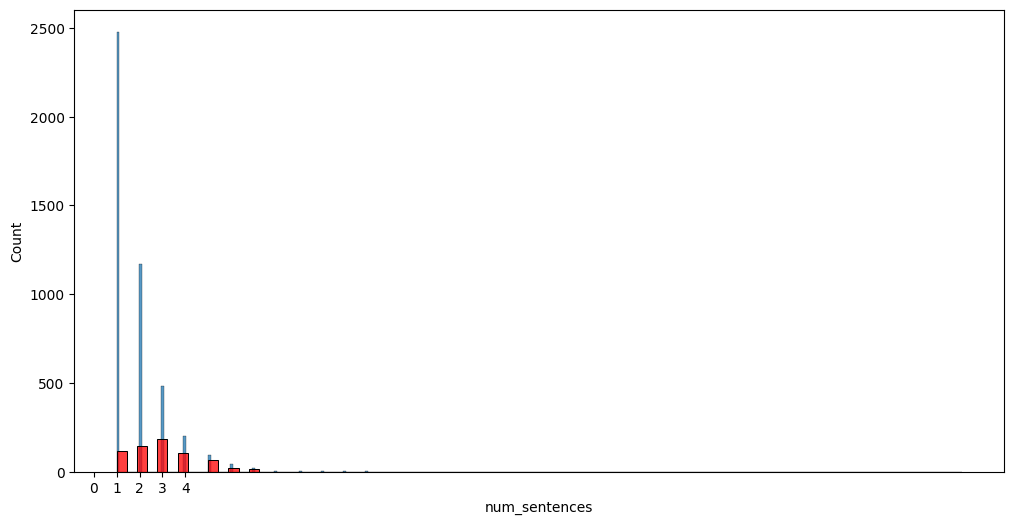

In [27]:
# For Number of sentences

plt.figure(figsize=(12,6))
sns.histplot(df[df['target'] == 0]['num_sentences'])
sns.histplot(df[df['target'] == 1]['num_sentences'],color='red')
plt.xticks(range(0,5))
plt.show()

- Similar to # of characters and words, ham messages has less # of sentences as compare to spam

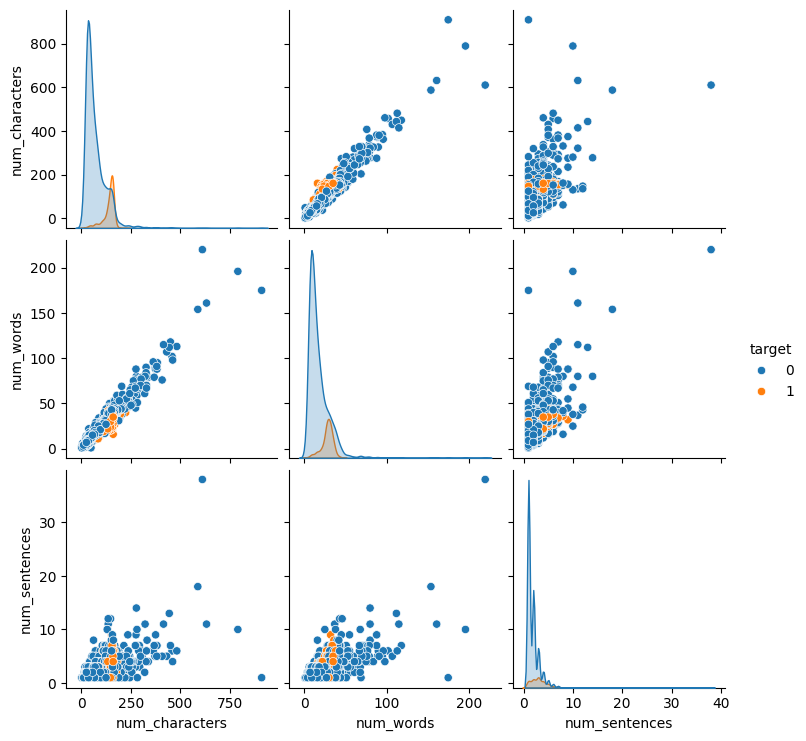

In [28]:
# Checking Relationship of each column with Target

sns.pairplot(df,hue='target')

- Data has Outliers and all the variable are showing different distribution for both of the classes of target variable and are right-skewed

<Axes: >

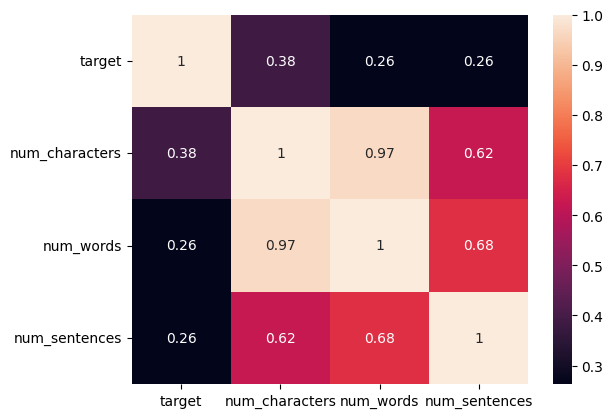

In [29]:
# Checking Co-relations

sns.heatmap(df.corr(numeric_only=True),annot=True)

Observation:
- target has max co-relation with num_character
- There is a high corelation between all the independent variable like, num_characters has 0.97 correlatio with num_words so clearly, there is a Multicolinearity in the data.
- To avoid Multicoliinearlity, we will only keep one feature out of 3 i.e num_character as it has max relation with target.

## 3. Text Preprocessing
- Lower case
- Removing special characters
- Tokenization
- Removing stop words and punctuation
- Stemming

In [30]:
def transform_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.translate(str.maketrans('','',string.punctuation)) # Removing Punctuation
    tokens = word_tokenize(text)  # Tokenization
    tokens1 = [PorterStemmer().stem(word) for word in tokens if word not in stopwords.words('english')]
                                                                        # Removing stopwords and performing stemming
    return " ".join(tokens1)


In [31]:
# Checking the function
print(df.text[10])
transform_text(df.text[10])

I'm gonna be home soon and i don't want to talk about this stuff anymore tonight, k? I've cried enough today.


'im gon na home soon dont want talk stuff anymor tonight k ive cri enough today'

In [32]:
# Applying transformation on Text Columns of our DataFrame and create a new column with the name 'transformed_text'

df['transformed_text'] = df['text'].apply(transform_text)

In [33]:
# Checking the data post Text Pre-processing

df.head()

,target,text,num_characters,num_words,num_sentences,transformed_text
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri wkli comp win fa cup final tkt st m...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah dont think goe usf live around though


- Now we have transformed_text, we can create a WordCloud for each class to see which words are getting repeated maximum

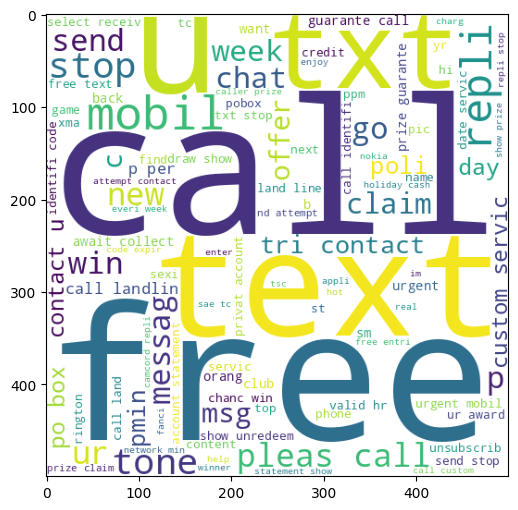

In [34]:
# Checking the WordCloud for spam

wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))

# Display WordCloud
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

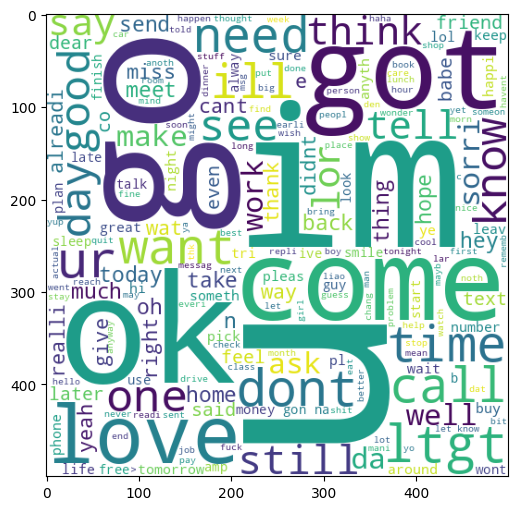

In [35]:
# Checking the WordCloud for ham messages

wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')
spam_wc = wc.generate(df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))

# Display WordCloud
plt.figure(figsize=(15,6))
plt.imshow(spam_wc)

-This is how WordCloud looks like for both classes, lets check for top 30 words in each class

In [36]:
# Checking Top 30 words in Spam -  To look into first 30 most common words, we will first extract all the words which belongs
# to Spam Class, Using below code

#df[df.target==1].iloc[:,-1].tolist() or df[df['target'] == 1]['transformed_text'].tolist() will give a list all the sentences
# in 'transformed_text column, then we will run loop on it which gives is each sentence then using split() function and
# another loop we will append each item into a dictonary

spam_word = []
for i in df[df.target==1].iloc[:,-1].tolist(): # for i in df[df['target'] == 1]['transformed_text'].tolist():
  for j in i.split():
    spam_word.append(j)

print('No. of Spam Words',len(spam_word))

# Now we a list of all spam word, to check the frequency of most common 30 days, we will use a library 'collections and
# from collection import Counter
# This counter will give a dictionary will keys as words and values a no of times that word is repeated
# Counter(spam_word) will give {'free': 190, 'entri': 21, 'wkli': 9 ...}
# then by using Counter().most_common(30) module can get most common 30 days

print('*******************')
print('Top 30 SpamWords:')
Counter(spam_word).most_common(30)

No. of Spam Words 9219
*******************
Top 30 SpamWords:


[('call', 324),
 ('free', 190),
 ('txt', 138),
 ('u', 130),
 ('text', 122),
 ('ur', 119),
 ('mobil', 115),
 ('stop', 106),
 ('repli', 101),
 ('claim', 98),
 ('prize', 82),
 ('get', 73),
 ('p', 65),
 ('new', 64),
 ('servic', 64),
 ('tone', 62),
 ('nokia', 60),
 ('send', 59),
 ('urgent', 58),
 ('award', 56),
 ('contact', 56),
 ('phone', 53),
 ('cash', 51),
 ('pleas', 51),
 ('week', 50),
 ('win', 49),
 ('min', 47),
 ('tc', 44),
 ('collect', 44),
 ('custom', 42)]

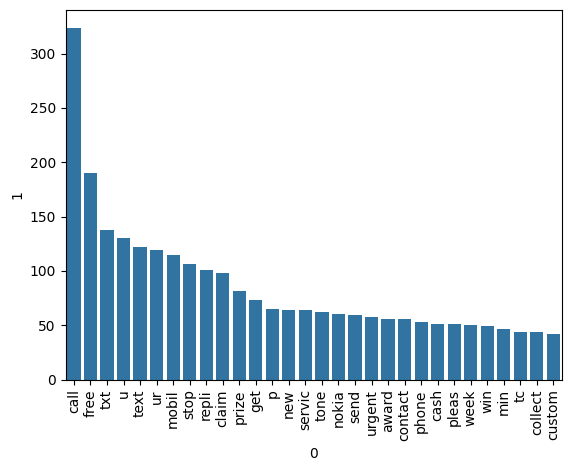

In [37]:
# Visualization

#To visualise we can use barplot, we can covert it into DataFram were 0th column will be X (Name of Words), 1st column will
# be Y(Frequency of the word)

sns.barplot(x= pd.DataFrame(Counter(spam_word).most_common(30))[0],y= pd.DataFrame(Counter(spam_word).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [38]:
# Checking Top 30 words in ham -

ham_word = []

for i in df[df.target==0].iloc[:,-1].tolist(): # for i in df[df['target'] == 1]['transformed_text'].tolist():
  for j in i.split():
    ham_word.append(j)

print('No. of Ham Words',len(ham_word))

# Now we a list of all ham word, to check the frequency of most common 30 days, we will use a library 'collections and
# from collection import Counter
# This counter will give a dictionary will keys as words and values a no of times that word is repeated
# Counter(spam_word) will give {'free': 190, 'entri': 21, 'wkli': 9 ...}
# then by using Counter().most_common(30) module can get most common 30 days

print('*******************')
print('Top 30 HamWords:')

Counter(ham_word).most_common(30)

No. of Ham Words 36050
*******************
Top 30 HamWords:


[('u', 890),
 ('im', 447),
 ('go', 403),
 ('get', 354),
 ('come', 272),
 ('ltgt', 254),
 ('dont', 253),
 ('ok', 246),
 ('got', 238),
 ('like', 232),
 ('know', 232),
 ('call', 232),
 ('time', 212),
 ('love', 211),
 ('ill', 210),
 ('want', 208),
 ('good', 206),
 ('ur', 197),
 ('day', 197),
 ('need', 171),
 ('one', 163),
 ('lor', 157),
 ('home', 151),
 ('think', 150),
 ('see', 146),
 ('still', 141),
 ('take', 137),
 ('tell', 133),
 ('make', 129),
 ('say', 127)]

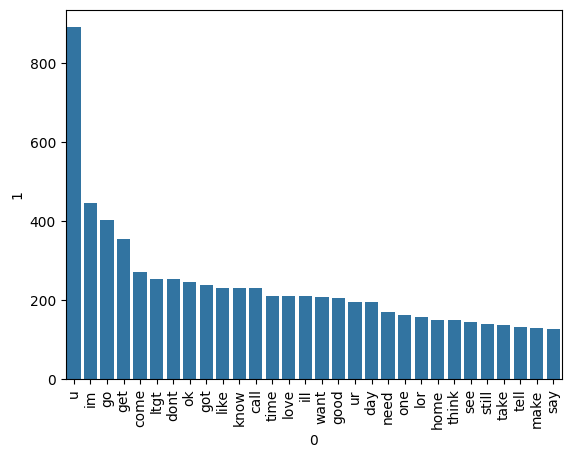

In [39]:
# Visualization

#To visualise we can use barplot, we can covert it into DataFram were 0th column will be X (Name of Words), 1st column will
# be Y(Frequency of the word)

sns.barplot(x= pd.DataFrame(Counter(ham_word).most_common(30))[0],y= pd.DataFrame(Counter(ham_word).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

## 4. Text Vectorization
  - We will use 2 approaches:
    - Using Bag of Words
    - Using TDIDF

In [40]:
# Approach 1: Using Bag of Words

cv = CountVectorizer()
vec = cv.fit_transform(df.transformed_text).toarray()
vec

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [41]:
vec.shape

(5169, 7050)

In [42]:
# Approach 2: Using TFIDF

tfidf = TfidfVectorizer()
vec1 = tfidf.fit_transform(df.transformed_text).toarray()
vec1

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [43]:
vec1.shape

(5169, 7050)

## 5. Modelling and Evaluation
 - For Modelling we will follow below approachs:
   Approach 1:
    - Trainig Naive Bayes alogrithm all the variants(GaussianNB, MultinomialNB, BernouliiNB) on transformed_text feature using BOW vectorization
    - Training Naive Bayes algorithm all variants (GaussianNB, MultinomialNB, BernouliiNB) on transformed_text and num_character features using BOW vectorization
  
  Approach 2:
    - Trainig Naive Bayes alogrithm all the variants(GaussianNB, MultinomialNB, BernouliiNB) on transformed_text feature using TDIDF vectorization
    - Training Naive Bayes algorithm all variants (GaussianNB, MultinomialNB, BernouliiNB) on transformed_text and num_character features using TDIDF vectorization

  Approach 3:
    - Based upon the best results from last 2 approaches Training other models

- For Evaluations, our main focus we will be on Precision Score and False Positive, since we have imbalance is class, Accuracy score is not a reliable message and this is a high precision based problem as we want out model to make less mistakes i.e False Positive should be lowest.

In [44]:
# Approach I = Separating the data into X and y (On the Basis of Bag of Words)

# Case I : Taking the X separately i.e only taking 'transformed_text' column

x = vec
y = df.target.values

In [45]:
# Spliting the data

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [46]:
# Using Naive Bayes

gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred_gnb = gnb.predict(x_test)
print('GaussinNB with BOW Results\n')
print('Accuracy : ',accuracy_score(y_test,y_pred_gnb))
print('Precision_Score : ', precision_score(y_test, y_pred_gnb))
print('Confusion Matrix for GaussianNB : \n', confusion_matrix(y_test,y_pred_gnb))


print('\n********************************************************************\n')


mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred_mnb = mnb.predict(x_test)
print('MultinomialNB with BOW Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_mnb))
print('Precision_Score : ', precision_score(y_test, y_pred_mnb))
print('\nConfusion Matrix for MultinomialNB : \n', confusion_matrix(y_test,y_pred_mnb))

print('\n********************************************************************\n')


bnb = BernoulliNB()
bnb.fit(x_train,y_train)
y_pred_bnb = bnb.predict(x_test)
print('BernollilNB with BOW Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_bnb))
print('Precision_Score : ', precision_score(y_test, y_pred_bnb))
print('\nConfusion Matrix for BernollilNB : \n', confusion_matrix(y_test,y_pred_bnb))


GaussinNB with BOW Results

Accuracy :  0.8617021276595744
Precision_Score :  0.48333333333333334
Confusion Matrix for GaussianNB : 
 [[775 124]
 [ 19 116]]

********************************************************************

MultinomialNB with BOW Results
Accuracy :  0.9661508704061895
Precision_Score :  0.8378378378378378

Confusion Matrix for MultinomialNB : 
 [[875  24]
 [ 11 124]]

********************************************************************

BernollilNB with BOW Results
Accuracy :  0.9535783365570599
Precision_Score :  0.9306930693069307

Confusion Matrix for BernollilNB : 
 [[892   7]
 [ 41  94]]


- As we can observe the best result is given by BernoliNB which has great precision score, False Positive is also 7. Since we have imbalance data so accuracy cannot be a good measure also, its a highly precision based problem hence our focus is on precision score and less False Positive as out model need to make less False Postive predictions.

In [47]:
# Case II - Here X will combination of vec from Bag of words and num_character column as we have discussed in EDA part due to high
# multicollinearity we will exclude the other two columns

x = np.concatenate([vec, df.num_characters.values.reshape(-1,1)],axis = 1)
y = df.target.values
# Checking x
x,y

(array([[  0,   0,   0, ...,   0,   0, 111],
        [  0,   0,   0, ...,   0,   0,  29],
        [  0,   0,   0, ...,   0,   0, 155],
        ...,
        [  0,   0,   0, ...,   0,   0,  57],
        [  0,   0,   0, ...,   0,   0, 125],
        [  0,   0,   0, ...,   0,   0,  26]]),
 array([0, 0, 1, ..., 0, 0, 0]))

In [48]:
# Spliting the data

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [49]:
# Applying Feature Scaling as added vectors is not on same scale as BOW vec
# We have selected MinMaxScaler because, StandardScaler will give the result into the range of (-1,1) and Naive Bayes will not
# work properly with negetive values where as MinMaxScaler gives the result in range of (0,1)

mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
x_test = mm.transform(x_test)

In [50]:
# Using Naive Bayes

gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred_gnb = gnb.predict(x_test)
print('GaussinNB with BOW Results\n')
print('Accuracy : ',accuracy_score(y_test,y_pred_gnb))
print('Precision_Score : ', precision_score(y_test, y_pred_gnb))
print('Confusion Matrix for GaussianNB : \n', confusion_matrix(y_test,y_pred_gnb))


print('\n********************************************************************\n')


mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred_mnb = mnb.predict(x_test)
print('MultinomialNB with BOW Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_mnb))
print('Precision_Score : ', precision_score(y_test, y_pred_mnb))
print('\nConfusion Matrix for MultinomialNB : \n', confusion_matrix(y_test,y_pred_mnb))

print('\n********************************************************************\n')


bnb = BernoulliNB()
bnb.fit(x_train,y_train)
y_pred_bnb = bnb.predict(x_test)
print('BernollilNB with BOW Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_bnb))
print('Precision_Score : ', precision_score(y_test, y_pred_bnb))
print('\nConfusion Matrix for BernollilNB : \n', confusion_matrix(y_test,y_pred_bnb))


GaussinNB with BOW Results

Accuracy :  0.8607350096711799
Precision_Score :  0.4810126582278481
Confusion Matrix for GaussianNB : 
 [[776 123]
 [ 21 114]]

********************************************************************

MultinomialNB with BOW Results
Accuracy :  0.9642166344294004
Precision_Score :  0.8602941176470589

Confusion Matrix for MultinomialNB : 
 [[880  19]
 [ 18 117]]

********************************************************************

BernollilNB with BOW Results
Accuracy :  0.9535783365570599
Precision_Score :  0.9306930693069307

Confusion Matrix for BernollilNB : 
 [[892   7]
 [ 41  94]]


- As observed output is almost similar if we added the num_character feature and Bernilli NB is giving best precision accuracy with lower False Positive

In [51]:
# Approach II = Separating the data into X and y (On the Basis of TFIDF)

# Case I : Taking the X separately i.e only taking 'transformed_text' column

x = vec1
y = df.target.values

In [52]:
# Spliting the data

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [53]:
# Using Naive Bayes

gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred_gnb = gnb.predict(x_test)
print('GaussinNB with TFIDF Results\n')
print('Accuracy : ',accuracy_score(y_test,y_pred_gnb))
print('Precision_Score : ', precision_score(y_test, y_pred_gnb))
print('Confusion Matrix for GaussianNB : \n', confusion_matrix(y_test,y_pred_gnb))


print('\n********************************************************************\n')


mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred_mnb = mnb.predict(x_test)
print('MultinomialNB with TFIDF Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_mnb))
print('Precision_Score : ', precision_score(y_test, y_pred_mnb))
print('\nConfusion Matrix for MultinomialNB : \n', confusion_matrix(y_test,y_pred_mnb))

print('\n********************************************************************\n')


bnb = BernoulliNB()
bnb.fit(x_train,y_train)
y_pred_bnb = bnb.predict(x_test)
print('BernollilNB with TFIDF Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_bnb))
print('Precision_Score : ', precision_score(y_test, y_pred_bnb))
print('\nConfusion Matrix for BernollilNB : \n', confusion_matrix(y_test,y_pred_bnb))


GaussinNB with TFIDF Results

Accuracy :  0.8539651837524178
Precision_Score :  0.4652173913043478
Confusion Matrix for GaussianNB : 
 [[776 123]
 [ 28 107]]

********************************************************************

MultinomialNB with TFIDF Results
Accuracy :  0.9516441005802708
Precision_Score :  1.0

Confusion Matrix for MultinomialNB : 
 [[899   0]
 [ 50  85]]

********************************************************************

BernollilNB with TFIDF Results
Accuracy :  0.9535783365570599
Precision_Score :  0.9306930693069307

Confusion Matrix for BernollilNB : 
 [[892   7]
 [ 41  94]]


- Result has been improved, For MultinomialNB, Accuracy and Precision has been improved and its giving 100% Precision Score with 0 False Positive whereas BernolliNB precision score and False Positive are same

In [54]:
# Case II - Here X will combination of vec from Bag of words and num_character column as we have discussed in EDA part due to high
# multicollinearity we will exclude the other two columns

x = np.concatenate([vec1, df.num_characters.values.reshape(-1,1)],axis = 1)
y = df.target.values

# Checking x
x,y

(array([[  0.,   0.,   0., ...,   0.,   0., 111.],
        [  0.,   0.,   0., ...,   0.,   0.,  29.],
        [  0.,   0.,   0., ...,   0.,   0., 155.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,  57.],
        [  0.,   0.,   0., ...,   0.,   0., 125.],
        [  0.,   0.,   0., ...,   0.,   0.,  26.]]),
 array([0, 0, 1, ..., 0, 0, 0]))

In [55]:
# Spliting the data

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=1)

In [56]:
# Applying Feature Scaling as added vector is not in same scale as BOW vec

mm = MinMaxScaler()
x_train = mm.fit_transform(x_train)
x_test = mm.transform(x_test)

In [57]:
# Using Naive Bayes

gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred_gnb = gnb.predict(x_test)
print('GaussinNB with TFIDF Results\n')
print('Accuracy : ',accuracy_score(y_test,y_pred_gnb))
print('Precision_Score : ', precision_score(y_test, y_pred_gnb))
print('Confusion Matrix for GaussianNB : \n', confusion_matrix(y_test,y_pred_gnb))


print('\n********************************************************************\n')


mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred_mnb = mnb.predict(x_test)
print('MultinomialNB with TFIDF Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_mnb))
print('Precision_Score : ', precision_score(y_test, y_pred_mnb))
print('\nConfusion Matrix for MultinomialNB : \n', confusion_matrix(y_test,y_pred_mnb))

print('\n********************************************************************\n')


bnb = BernoulliNB()
bnb.fit(x_train,y_train)
y_pred_bnb = bnb.predict(x_test)
print('BernollilNB with TFIDF Results')
print('Accuracy : ',accuracy_score(y_test,y_pred_bnb))
print('Precision_Score : ', precision_score(y_test, y_pred_bnb))
print('\nConfusion Matrix for BernollilNB : \n', confusion_matrix(y_test,y_pred_bnb))


GaussinNB with TFIDF Results

Accuracy :  0.851063829787234
Precision_Score :  0.4605809128630705
Confusion Matrix for GaussianNB : 
 [[769 130]
 [ 24 111]]

********************************************************************

MultinomialNB with TFIDF Results
Accuracy :  0.971953578336557
Precision_Score :  0.9274193548387096

Confusion Matrix for MultinomialNB : 
 [[890   9]
 [ 20 115]]

********************************************************************

BernollilNB with TFIDF Results
Accuracy :  0.9535783365570599
Precision_Score :  0.9306930693069307

Confusion Matrix for BernollilNB : 
 [[892   7]
 [ 41  94]]


- As observed, for MultinomialNB the precision score has been reduced to 92.7% from 100% along with False Positive increase to 7, For BernolliNB its same, so with TFIDF the added column, num_character has reduce the Precision Score for MultinomialNB however for there is no impact on BernolliNB and GaussianNB is showing poor Precision Score in all the cases

So based on overall results, we will choose TFIDF with MultinomailNB wihtout adding num_charaters feature to the X. i.e Aproach II, Case-I

In [58]:
## Aproach III - Using other ML Algorithms

# We will be using following ML Models
# Support Vector Machine Classifer
# KNN Classifier
# MultinomialNB
# Decision Tree Classifier
# Logistic Regression Classifer
# RandomForest Classifier
# Bagging Classifier
# Gradient Boosting Classifier
# XGBoost Classifier

# Note : As per the best result obtained from last 2 approaches, we will be training all of the models on 'transformed_text'
# feauture only exluding 'num_character' feauture with TFIDF vectorization method.

In [59]:
# Splitng the data (We will Using TFIDF without adding num_character feature as we were getting the Best Result in that only)

x = vec1
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)


#Creating the Model Objects

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)


# Creating a dictonary with Model Name and Object

clfs = {
    'SVC' : svc,
    'KNN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'GBDT':gbdt,
    'xgb':xgb
}

# Creating a functions to execute all of them

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision


# Storing the precision score and accuracy score into list

accuracy_scores = []
precision_scores = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, x_train,y_train,x_test,y_test)

    print("For",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print('\n***********************\n')

    accuracy_scores.append(current_accuracy)
    precision_scores.append(current_precision)

For SVC
Accuracy -  0.9748549323017408
Precision -  0.9739130434782609

***********************

For KNN
Accuracy -  0.90715667311412
Precision -  1.0

***********************

For NB
Accuracy -  0.9516441005802708
Precision -  1.0

***********************

For DT
Accuracy -  0.9081237911025145
Precision -  0.717391304347826

***********************

For LR
Accuracy -  0.9497098646034816
Precision -  0.9191919191919192

***********************

For RF
Accuracy -  0.9622823984526112
Precision -  1.0

***********************

For AdaBoost
Accuracy -  0.9081237911025145
Precision -  0.7702702702702703

***********************

For BgC
Accuracy -  0.941972920696325
Precision -  0.8151260504201681

***********************

For GBDT
Accuracy -  0.9410058027079303
Precision -  0.9204545454545454

***********************

For xgb
Accuracy -  0.9497098646034816
Precision -  0.8807339449541285

***********************



In [60]:
# Storing the Results into DataFrame for Comparision

performance_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy':accuracy_scores,'Precision':precision_scores}).sort_values('Precision',ascending=False)

In [61]:
# Checking the DataFrame

performance_df

,Algorithm,Accuracy,Precision
1,KNN,0.907157,1.000000
2,NB,0.951644,1.000000
5,RF,0.962282,1.000000
0,SVC,0.974855,0.973913
8,GBDT,0.941006,0.920455
4,LR,0.949710,0.919192
9,xgb,0.949710,0.880734
7,BgC,0.941973,0.815126
6,AdaBoost,0.908124,0.770270
3,DT,0.908124,0.717391


In [62]:
# Observations based on the provided performance_df:

# 1. SVC Model:
#   - Highest accuracy (0.974855) and a high precision score (0.973913).
#   - This indicates that the SVC model performs very well in correctly classifying the target variable.
# 2. RF and NB Models:
#   - Very high accuracy (around 0.95 - 0.96) and perfect precision (1.0).
#   - Perfect precision is noteworthy, meaning these models do not produce any false positive results.


# 3. Other Models:
#   - Most other models (LR, GBDT, xgb, BgC, AdaBoost, DT, KNN) show a decrease in precision.
#   - The precision score drops significantly for these models as compared to the top 3.
#   - The lower precision indicates more false positives, which is crucial to consider in this context.

# 4. Overall:
#   - The SVC model stands out as the top performer, balancing high accuracy with strong precision.
#   - RF and NB are strong contenders due to perfect precision.
#   - The rest of the models show a declining precision suggesting a higher probability of false positives.

# 5. Model Choice:
#   - If minimizing false positives is a priority, SVC is an excellent option, followed by RF and NB.
#   - If balancing accuracy and precision is important, then SVC is the clear choice.It offers a strong tradeoff between both metrics.


## 6.Improve Model Performance

- To improve the model performance we will apply following steps
  - Change the max_feautes into TFIDF
  - Apply feature scaling
  - Add num_character features into predictors
  - Apply Ensemble Techinques
      - Voting Classifier('hard' and 'soft' voting)
      - Stacking Classifier

In [63]:
# 1. Change the max_feature parameter of TFIDF

tfidf = TfidfVectorizer(max_features = 3000)
vec1 = tfidf.fit_transform(df.transformed_text).toarray()
vec1

# Splitng the data (We will Using TFIDF with adding num_character feature as we were getting the Best Result in that only)
x = vec1
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)


#Creating the Model Objects

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)


# Creating a dictonary with Model Name and Object

clfs = {
    'SVC' : svc,
    'KNN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'GBDT':gbdt,
    'xgb':xgb
}

# Creating a functions to execute all of them

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision


# Storing the precision score and accuracy score into list

accuracy_max_ft_3000 = []
precision_max_ft_3000 = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, x_train,y_train,x_test,y_test)

    print("For",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print('\n***********************\n')

    accuracy_max_ft_3000.append(current_accuracy)
    precision_max_ft_3000.append(current_precision)

For SVC
Accuracy -  0.9700193423597679
Precision -  0.9482758620689655

***********************

For KNN
Accuracy -  0.9197292069632496
Precision -  1.0

***********************

For NB
Accuracy -  0.9680851063829787
Precision -  1.0

***********************

For DT
Accuracy -  0.913926499032882
Precision -  0.7804878048780488

***********************

For LR
Accuracy -  0.9497098646034816
Precision -  0.9108910891089109

***********************

For RF
Accuracy -  0.9671179883945842
Precision -  0.963302752293578

***********************

For AdaBoost
Accuracy -  0.9052224371373307
Precision -  0.7402597402597403

***********************

For BgC
Accuracy -  0.941972920696325
Precision -  0.8205128205128205

***********************

For GBDT
Accuracy -  0.9410058027079303
Precision -  0.9302325581395349

***********************

For xgb
Accuracy -  0.9584139264990329
Precision -  0.9259259259259259

***********************



In [64]:
# Storing with old results

temp_df = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_max_ft_3000':accuracy_max_ft_3000,'Precision_max_ft_3000':precision_max_ft_3000}).sort_values('Precision_max_ft_3000',ascending=False)
new_df = performance_df.merge(temp_df,on='Algorithm')
new_df

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_max_ft_3000
0,KNN,0.907157,1.000000,0.919729,1.000000
1,NB,0.951644,1.000000,0.968085,1.000000
2,RF,0.962282,1.000000,0.967118,0.963303
3,SVC,0.974855,0.973913,0.970019,0.948276
4,GBDT,0.941006,0.920455,0.941006,0.930233
5,LR,0.949710,0.919192,0.949710,0.910891
6,xgb,0.949710,0.880734,0.958414,0.925926
7,BgC,0.941973,0.815126,0.941973,0.820513
8,AdaBoost,0.908124,0.770270,0.905222,0.740260
9,DT,0.908124,0.717391,0.913926,0.780488


Overall Performance:
- The models generally show high accuracy and precision, indicating good performance in classifying the target variable.  SVC, RF, and NB consistently rank high.

-Impact of max_features:
 - Changing the `max_features` parameter in TFIDF to 3000 had a mixed impact. Some models, notably RandomForest and Naive Bayes, saw improvements in accuracy while maintaining perfect precision. ]

- Model Stability:
 - The precision scores for SVC, RF, and NB remain highly stable, even after adjusting max features. This indicates their robustness.


In [65]:
# 2.Apply feature scaling

tfidf = TfidfVectorizer(max_features = 3000)
vec1 = tfidf.fit_transform(df.transformed_text).toarray()
vec1

# Splitng the data (We will Using TFIDF with adding num_character feature as we were getting the Best Result in that only)
x = vec1
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)


# Applying Feature Scaling
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

#Creating the Model Objects

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)


# Creating a dictonary with Model Name and Object

clfs = {
    'SVC' : svc,
    'KNN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'GBDT':gbdt,
    'xgb':xgb
}

# Creating a functions to execute all of them

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision


# Storing the precision score and accuracy score into list

accuracy_max_ft_3000_scale = []
precision_max_ft_3000_scale = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, x_train,y_train,x_test,y_test)

    print("For",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print('\n***********************\n')

    accuracy_max_ft_3000_scale.append(current_accuracy)
    precision_max_ft_3000_scale.append(current_precision)

For SVC
Accuracy -  0.9545454545454546
Precision -  0.8666666666666667

***********************

For KNN
Accuracy -  0.9168278529980658
Precision -  0.9622641509433962

***********************

For NB
Accuracy -  0.9700193423597679
Precision -  0.9

***********************

For DT
Accuracy -  0.913926499032882
Precision -  0.7804878048780488

***********************

For LR
Accuracy -  0.9613152804642167
Precision -  0.9357798165137615

***********************

For RF
Accuracy -  0.9671179883945842
Precision -  0.963302752293578

***********************

For AdaBoost
Accuracy -  0.9052224371373307
Precision -  0.7402597402597403

***********************

For BgC
Accuracy -  0.941972920696325
Precision -  0.8205128205128205

***********************

For GBDT
Accuracy -  0.9410058027079303
Precision -  0.9302325581395349

***********************

For xgb
Accuracy -  0.9584139264990329
Precision -  0.9259259259259259

***********************



In [66]:
# Combining the results

temp_df1= pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_scaling':accuracy_max_ft_3000_scale,'Precision_scaling':precision_max_ft_3000_scale}).sort_values('Precision_scaling',ascending=False)
new_df_scaled = new_df.merge(temp_df1,on='Algorithm')
new_df_scaled

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_max_ft_3000,Accuracy_scaling,Precision_scaling
0,KNN,0.907157,1.000000,0.919729,1.000000,0.916828,0.962264
1,NB,0.951644,1.000000,0.968085,1.000000,0.970019,0.900000
2,RF,0.962282,1.000000,0.967118,0.963303,0.967118,0.963303
3,SVC,0.974855,0.973913,0.970019,0.948276,0.954545,0.866667
4,GBDT,0.941006,0.920455,0.941006,0.930233,0.941006,0.930233
5,LR,0.949710,0.919192,0.949710,0.910891,0.961315,0.935780
6,xgb,0.949710,0.880734,0.958414,0.925926,0.958414,0.925926
7,BgC,0.941973,0.815126,0.941973,0.820513,0.941973,0.820513
8,AdaBoost,0.908124,0.770270,0.905222,0.740260,0.905222,0.740260
9,DT,0.908124,0.717391,0.913926,0.780488,0.913926,0.780488


Observations:
- SVC has the highest accuracy (0.974855) and high precision (0.973913).
- RF and NB have perfect precision (1.000000) but slightly lower accuracy.
- Increasing max_features to 3000 generally improves accuracy but has mixed results on precision.
- Applying feature scaling also results in mixed changes in both accuracy and precision.
- GBDT, LR, xgboost, BgC, AdaBoost, and DT have relatively lower precision scores.
- Overall, SVC seems like the best option balancing accuracy and precision. However since our porblem is high precison problem we will consider either RF and NB with give high precision score with decent accuracy, however feature scaling has no impact on RF shows its robustness but in generally feature scaling has reduced the precision scores for distance base model like, SVC, KNN so we will not consider feature scaling

In [67]:
# 3.Including num_character into X with Scaling


tfidf = TfidfVectorizer(max_features = 3000)
vec1 = tfidf.fit_transform(df.transformed_text).toarray()
vec1

# Splitng the data (We will Using TFIDF with adding num_character feature as we were getting the Best Result in that only)
x = np.concatenate([vec1,df.num_characters.values.reshape(-1,1)],axis=1)
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)


# Applying Feature Scaling
mms = MinMaxScaler()
x_train = mms.fit_transform(x_train)
x_test = mms.transform(x_test)

#Creating the Model Objects

svc = SVC(kernel='sigmoid', gamma=1.0)
knc = KNeighborsClassifier()
mnb = MultinomialNB()
dtc = DecisionTreeClassifier(max_depth=5)
lrc = LogisticRegression(solver='liblinear', penalty='l1')
rfc = RandomForestClassifier(n_estimators=50, random_state=2)
abc = AdaBoostClassifier(n_estimators=50, random_state=2)
bc = BaggingClassifier(n_estimators=50, random_state=2)
gbdt = GradientBoostingClassifier(n_estimators=50,random_state=2)
xgb = XGBClassifier(n_estimators=50,random_state=2)


# Creating a dictonary with Model Name and Object

clfs = {
    'SVC' : svc,
    'KNN' : knc,
    'NB': mnb,
    'DT': dtc,
    'LR': lrc,
    'RF': rfc,
    'AdaBoost': abc,
    'BgC': bc,
    'GBDT':gbdt,
    'xgb':xgb
}

# Creating a functions to execute all of them

def train_classifier(clf,X_train,y_train,X_test,y_test):
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    return accuracy,precision


# Storing the precision score and accuracy score into list

accuracy_num_char = []
precision_num_char = []

for name,clf in clfs.items():

    current_accuracy,current_precision = train_classifier(clf, x_train,y_train,x_test,y_test)

    print("For",name)
    print("Accuracy - ",current_accuracy)
    print("Precision - ",current_precision)
    print('\n***********************\n')

    accuracy_num_char.append(current_accuracy)
    precision_num_char.append(current_precision)



For SVC
Accuracy -  0.9584139264990329
Precision -  0.8833333333333333

***********************

For KNN
Accuracy -  0.9090909090909091
Precision -  0.9555555555555556

***********************

For NB
Accuracy -  0.9700193423597679
Precision -  0.9

***********************

For DT
Accuracy -  0.9342359767891683
Precision -  0.8526315789473684

***********************

For LR
Accuracy -  0.9613152804642167
Precision -  0.9439252336448598

***********************

For RF
Accuracy -  0.9690522243713733
Precision -  1.0

***********************

For AdaBoost
Accuracy -  0.9313346228239845
Precision -  0.8636363636363636

***********************

For BgC
Accuracy -  0.9584139264990329
Precision -  0.8833333333333333

***********************

For GBDT
Accuracy -  0.9381044487427466
Precision -  0.9080459770114943

***********************

For xgb
Accuracy -  0.9564796905222437
Precision -  0.9166666666666666

***********************



In [68]:
# Combining the data

temp_df2 = pd.DataFrame({'Algorithm':clfs.keys(),'Accuracy_num_chars':accuracy_num_char,'Precision_num_chars':precision_num_char}).sort_values('Precision_num_chars',ascending=False)
final_df = new_df_scaled.merge(temp_df2, on = 'Algorithm')
final_df

,Algorithm,Accuracy,Precision,Accuracy_max_ft_3000,Precision_max_ft_3000,Accuracy_scaling,Precision_scaling,Accuracy_num_chars,Precision_num_chars
0,KNN,0.907157,1.000000,0.919729,1.000000,0.916828,0.962264,0.909091,0.955556
1,NB,0.951644,1.000000,0.968085,1.000000,0.970019,0.900000,0.970019,0.900000
2,RF,0.962282,1.000000,0.967118,0.963303,0.967118,0.963303,0.969052,1.000000
3,SVC,0.974855,0.973913,0.970019,0.948276,0.954545,0.866667,0.958414,0.883333
4,GBDT,0.941006,0.920455,0.941006,0.930233,0.941006,0.930233,0.938104,0.908046
5,LR,0.949710,0.919192,0.949710,0.910891,0.961315,0.935780,0.961315,0.943925
6,xgb,0.949710,0.880734,0.958414,0.925926,0.958414,0.925926,0.956480,0.916667
7,BgC,0.941973,0.815126,0.941973,0.820513,0.941973,0.820513,0.958414,0.883333
8,AdaBoost,0.908124,0.770270,0.905222,0.740260,0.905222,0.740260,0.931335,0.863636
9,DT,0.908124,0.717391,0.913926,0.780488,0.913926,0.780488,0.934236,0.852632


Observations based on the provided DataFrame:

- Overall Performance: The models generally show high accuracy and precision, indicating good performance in classifying the target variable. SVC, RF, and NB consistently rank high.

- Impact of max_features:Changing the `max_features` parameter in TFIDF to 3000 had a mixed impact. Some models, notably RandomForest and Naive Bayes, saw improvements in accuracy while maintaining perfect precision.

- Model Stability: The precision scores for SVC, RF, and NB remain highly stable, even after adjusting max features. This indicates their robustness.

- Impact of Feature Scaling: Feature scaling had mixed effects on the models. Some saw slight improvements, others saw reductions in precision.

- Impact of Adding 'num_characters' feature: Adding the 'num_characters' feature yielded varying results.  It improved the precision of some models but harmed it in others.

- Model Choice:
 - If minimizing false positives is a priority, RF and NB (in certain configurations) are excellent options.
 - If balancing accuracy and precision is important, SVC generally offers a good tradeoff.

- Since our problem is high precision based problem, we will consider Naive Bayes which has shown its robustness keeping the precision score 100%.

In [69]:
#4. Applying Voting Classifier (Ensemble Learning)
# We will use our best models SVC, Naive Bayes and RandomForest to build a voting classifier to see if we improve

# Using TFIDF with max_features = 3000

tfidf = TfidfVectorizer(max_features = 3000)
vec1 = tfidf.fit_transform(df.transformed_text).toarray()
vec1

# Splitng the data
x = vec1
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)

# Creating Voting Classifier - SOFT Voting

svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=500, random_state=2)

voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('rf', rf)],voting='soft')
voting.fit(x_train,y_train)
print('VotingClassifier with Soft Voting Accuracy : ', voting.score(x_test,y_test))
print('VotingClassifier with Soft Voting Precision : ', precision_score(y_test, voting.predict(x_test)))

print('\n***************************\n')

# Creating Voting Classifier - Hard Voting

svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=500, random_state=2)

voting = VotingClassifier(estimators=[('svm', svc), ('nb', mnb), ('rf', rf)],voting='hard')
voting.fit(x_train,y_train)
print('VotingClassifier with Hard Voting Accuracy : ', voting.score(x_test,y_test))
print('VotingClassifier with Hard Voting Precision : ', precision_score(y_test, voting.predict(x_test)))


VotingClassifier with Soft Voting Accuracy :  0.9777562862669246
VotingClassifier with Soft Voting Precision :  0.9745762711864406

***************************

VotingClassifier with Hard Voting Accuracy :  0.9738878143133463
VotingClassifier with Hard Voting Precision :  1.0


- As observed, VotingClassifer with Hard voting is giving better precision score as compare with soft voting

In [70]:
# 5.Applying Stacking Classifier
# We will use our best models SVC, Naive Bayes and RandomForest to build a Stacking classifier to see if we improve

# Using TFIDF with max_features = 3000

tfidf = TfidfVectorizer(max_features = 3000)
vec1 = tfidf.fit_transform(df.transformed_text).toarray()
vec1

# Splitng the data
x = vec1
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)

# Creating Stacking Classifier

svc = SVC(kernel='sigmoid', gamma=1.0,probability=True)
mnb = MultinomialNB()
rf = RandomForestClassifier(n_estimators=500, random_state=2)


estimators=[('svm', svc), ('nb', mnb), ('rf', rf)]
final_estimator = LogisticRegression()

clf = StackingClassifier(estimators=estimators, final_estimator=final_estimator)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
print("Stacking Classifier Accuracy",accuracy_score(y_test,y_pred))
print("Stacking Classifier Precision",precision_score(y_test,y_pred))


Stacking Classifier Accuracy 0.9777562862669246
Stacking Classifier Precision 0.9444444444444444


- So Stacking Classifer is giving us the lower precision score  as compare to Voting Classifer
- Based upon all the result we have 2 best model
  - Voting Classifier with Hard voting
  - MultimomialNB with TfIDF vectorization

In [71]:
# Comparing both to make the final call

mnb = MultinomialNB()

tfidf_final = TfidfVectorizer(max_features = 3000)
vec1 = tfidf_final.fit_transform(df.transformed_text).toarray()
print(vec1,vec1.shape)

# Splitng the data
x = vec1
y = df.target.values

x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2, random_state=1)

mnb = MultinomialNB()
mnb.fit(x_train,y_train)
y_pred_mnb = mnb.predict(x_test)
print('Accuracy with MultinomialNB: ',mnb.score(x_test,y_test))
print('Precision Score with MultinomialNB', precision_score(y_test,y_pred_mnb))
print('ConfusionMatrix for MultinomialNB\n', confusion_matrix(y_test,y_pred_mnb))

print('\n***********************************\n')

print('Accuracy with VotingClassifier: ',voting.score(x_test,y_test))
print('Precision Score with VotingClassifier', precision_score(y_test,voting.predict(x_test)))
print('ConfusionMatrix for VotingClassifier\n', confusion_matrix(y_test,voting.predict(x_test)))



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] (5169, 3000)
Accuracy with MultinomialNB:  0.9680851063829787
Precision Score with MultinomialNB 1.0
ConfusionMatrix for MultinomialNB
 [[899   0]
 [ 33 102]]

***********************************

Accuracy with VotingClassifier:  0.9738878143133463
Precision Score with VotingClassifier 1.0
ConfusionMatrix for VotingClassifier
 [[899   0]
 [ 27 108]]


Observation:
 - Accuracy Score of Voting Classifier is Higher than MultinomialNB
 - Precision Score is same for both 100%
 - False Positive is also same for both i.e 0
 - False Negetive for voting classifer is less as compare to MultinomialNB


 Overall performance of voting classifier is better so we will choose VotingClassifier with 'hard' voting as our final model.

In [78]:
# Storing the object

import pickle

pickle.dump(transform_text, open('text_preprocessing.pkl','wb')) # Storing for Text Pre-processing
pickle.dump(tfidf_final,open('text_vectorizer.pkl','wb')) # Storing for Text Vecotrization
pickle.dump(voting,open('final_model.pkl','wb')) # Stroing for Model


In [79]:
# Prediction


with open('text_vectorizer.pkl','rb') as fh:
  vect = pickle.load(fh)


text = 'hi'
ttext = transform_text(text)
vec = vect.transform([ttext])

In [80]:
vec.shape

(1, 3000)

In [84]:
voting.predict(vec.toarray())

array([0])

In [83]:
with open('text_preprocessing.pkl','rb') as fh:
  tpp = pickle.load(fh)

tpp(df.text[3])


'u dun say earli hor u c alreadi say'

- Our Model is ready, we will now create a wensite using Pycharm and streamlit library, Below is the code in pycharm

In [77]:
# import pickle
# import re
# import string
# import streamlit as st
# from nltk.corpus import stopwords
# from nltk.stem import PorterStemmer
# from nltk.tokenize import word_tokenize
# import numpy as np

# with open('vectorizer.pkl', 'rb') as tf:
#     tfidf = pickle.load(tf)
# with open('model.pkl', 'rb') as m:
#     model = pickle.load(m)

# st.title('Email/SMS Spam Classifier')

# input_sms = st.text_area("Enter the message")


# # Step1: Text Pre-process

# def transform_text(text):
#     text = text.lower()  # Convert to lowercase
#     text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
#     text = text.translate(str.maketrans('', '', string.punctuation))  # Removing Punctuation
#     tokens = word_tokenize(text)  # Tokenization
#     tokens1 = [PorterStemmer().stem(word) for word in tokens if word not in stopwords.words('english')]
#                                                             # Removing Stop word and Stemming

#     return " ".join(tokens1)


# transformed_sms = transform_text(input_sms)

# if st.button('Predict'):
#     # Step2: Text Vectorization
#     vec = tfidf.transform([transformed_sms])

#     # Step3: Modeling
#     result = model.predict(vec)[0]

#     # Step4: Display
#     if result == 1:
#         st.header('SPAM')
#     else:
#         st.header('NOT SPAM')
